In [150]:
# Import required packages
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

In [12]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [169]:
start_time = time.time()

In [170]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [171]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [172]:
end_time = time.time()
model_0_training_time = end_time - start_time
print("Baseline model training time: {} seconds".format(model_0_training_time))

Baseline model training time: 12.347363948822021 seconds


For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [15]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [39]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [158]:
config = Namespace(image_height=32, image_width=32, num_channels=3, 
                   num_classes=10, n_layers=2, n_epochs=10)

In [159]:
# train: 40000 labels, val: 5000 labels, test: 5000 labels
x_train= imgs[10000:]/255
x_val= imgs[:5000]/255
x_test= imgs[5000:10000]/255

y_train= noisy_labels[10000:]
y_val= noisy_labels[:5000]
y_test = noisy_labels[5000:10000]

In [160]:
class ImageClassifier:
    def __init__(self, image_height, image_width, num_channels, num_classes, n_layers):
        self.image_height = image_height
        self.image_width = image_width
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.model = self.build_model()
        
    def build_model(self):
        model = models.Sequential()
        
        for n in range(self.n_layers):
            model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.image_height, self.image_width, self.num_channels)))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(0.2))
            
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes,activation="softmax"))
        
        return model

In [161]:
model_1 = ImageClassifier(config.image_height, config.image_width, 
                        config.num_channels, config.num_classes, config.n_layers).model

In [162]:
model_1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)            

In [163]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()
history = model_1.fit(x_train, y_train, epochs=config.n_epochs, 
                    validation_data=(x_val, y_val))
end_time = time.time()

model_1_training_time = end_time - start_time
print("Model 1 training time: {} seconds".format(model_1_training_time)

Epoch 1/10
1250/1250 [==============================] - 28s 23ms/step - loss: 2.2947 - accuracy: 0.1238 - val_loss: 2.2733 - val_accuracy: 0.1590
Epoch 2/10
1250/1250 [==============================] - 25s 20ms/step - loss: 2.2747 - accuracy: 0.1562 - val_loss: 2.2515 - val_accuracy: 0.1894
Epoch 3/10
1250/1250 [==============================] - 23s 18ms/step - loss: 2.2648 - accuracy: 0.1719 - val_loss: 2.2434 - val_accuracy: 0.1994
Epoch 4/10
1250/1250 [==============================] - 23s 18ms/step - loss: 2.2572 - accuracy: 0.1828 - val_loss: 2.2373 - val_accuracy: 0.2096
Epoch 5/10
1250/1250 [==============================] - 22s 18ms/step - loss: 2.2519 - accuracy: 0.1870 - val_loss: 2.2300 - val_accuracy: 0.2196
Epoch 6/10
1250/1250 [==============================] - 23s 18ms/step - loss: 2.2473 - accuracy: 0.1949 - val_loss: 2.2298 - val_accuracy: 0.2148
Epoch 7/10
1250/1250 [==============================] - 24s 19ms/step - loss: 2.2432 - accuracy: 0.2002 - val_loss: 2.2302 -

In [177]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    class_prob = model_1.predict(np.array([image])/225)
    return np.argmax(class_prob, axis = -1)

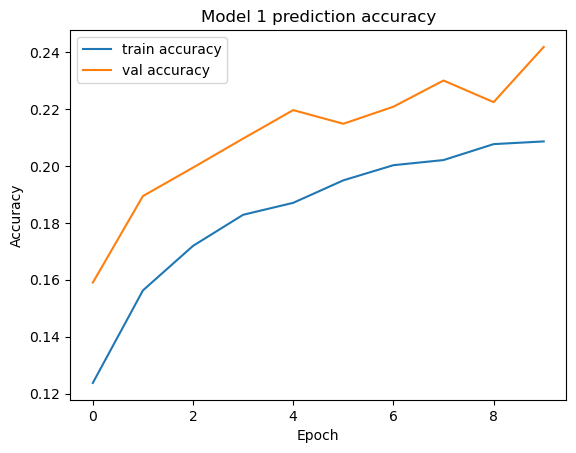

157/157 - 1s - loss: 2.2220 - accuracy: 0.2226


In [165]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model 1 prediction accuracy")
plt.legend()
plt.show()

test_loss, test_acc = model_1.evaluate(x_test, y_test, verbose=2)

### 2.3. Model II

In [151]:
edited_labels = pd.read_csv('../data/edited_labels.csv', delimiter=',', dtype="int8").to_numpy().flatten()

In [152]:
# train: 40000 labels, val: 5000 labels, test: 5000 labels
x_train= imgs[10000:]/255
x_val= imgs[:5000]/255
x_test= imgs[5000:10000]/255

y_train= edited_labels[10000:]
y_val= edited_labels[:5000]
y_test = edited_labels[5000:10000]

In [153]:
model_2 = ImageClassifier(config.image_height, config.image_width, 
                        config.num_channels, config.num_classes, config.n_layers).model

In [154]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()
history = model_2.fit(x_train, y_train, epochs=config.n_epochs, 
                    validation_data=(x_val, y_val))
end_time = time.time()

model_2_training_time = end_time - start_time
print("Model 2 training time: {} seconds".format(model_2_training_time))

Epoch 1/10
1250/1250 [==============================] - 20s 16ms/step - loss: 2.1175 - accuracy: 0.3386 - val_loss: 2.1044 - val_accuracy: 0.3500
Epoch 2/10
1250/1250 [==============================] - 21s 17ms/step - loss: 2.0084 - accuracy: 0.4527 - val_loss: 2.0532 - val_accuracy: 0.4020
Epoch 3/10
1250/1250 [==============================] - 23s 18ms/step - loss: 1.9754 - accuracy: 0.4847 - val_loss: 2.0463 - val_accuracy: 0.4088
Epoch 4/10
1250/1250 [==============================] - 22s 18ms/step - loss: 1.9539 - accuracy: 0.5066 - val_loss: 2.0361 - val_accuracy: 0.4208
Epoch 5/10
1250/1250 [==============================] - 22s 18ms/step - loss: 1.9456 - accuracy: 0.5144 - val_loss: 2.0131 - val_accuracy: 0.4422
Epoch 6/10
1250/1250 [==============================] - 23s 18ms/step - loss: 1.9346 - accuracy: 0.5246 - val_loss: 2.0155 - val_accuracy: 0.4420
Epoch 7/10
1250/1250 [==============================] - 22s 17ms/step - loss: 1.9304 - accuracy: 0.5284 - val_loss: 2.0159 -

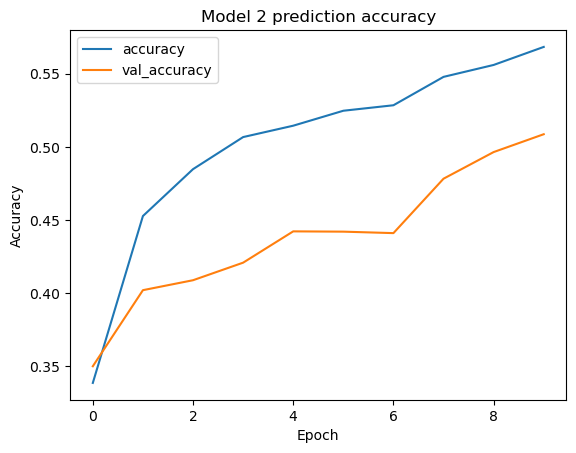

157/157 - 1s - loss: 2.0425 - accuracy: 0.4320


In [155]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model 2 prediction accuracy")
plt.legend()
plt.show()

test_loss, test_acc = model_2.evaluate(x_test, y_test, verbose=2)

In [156]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    class_prob = model_2.predict(np.array([image])/225)
    return np.argmax(class_prob, axis = -1)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [148]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [157]:
test_imgs = imgs[0:10000]
test_labels = clean_labels

start_time = time.time()
evaluation(baseline_model, test_labels, test_imgs)
end_time = time.time()

model_0_evaluation_time = end_time - start_time
print("Baseline model evaluation time: {} seconds".format(model_0_evaluation_time))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000

Baseline model evaluation time: 3.4444079399108887 seconds


In [182]:
test_imgs = imgs[0:10000]
test_labels = clean_labels

start_time = time.time()
evaluation(model_I, test_labels, test_imgs)
end_time = time.time()

model_1_evaluation_time = end_time - start_time
print("Model 1 evaluation time: {} seconds".format(model_1_evaluation_time))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49      1005
           1       0.62      0.66      0.64       974
           2       0.37      0.25      0.30      1032
           3       0.38      0.32      0.35      1016
           4       0.38      0.48      0.42       999
           5       0.38      0.53      0.44       937
           6       0.61      0.45      0.52      1030
           7       0.62      0.56      0.59      1001
           8       0.53      0.68      0.60      1025
           9       0.58      0.54      0.56       981

    accuracy                           0.49     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.50      0.49      0.49     10000

Model 1 evaluation time: 309.53437399864197 seconds


In [167]:
start_time = time.time()
evaluation(model_II, test_labels, test_imgs)
end_time = time.time()

model_2_evaluation_time = end_time - start_time
print("Model 2 evaluation time: {} seconds".format(model_2_evaluation_time))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55      1005
           1       0.56      0.74      0.64       974
           2       0.40      0.15      0.22      1032
           3       0.00      0.00      0.00      1016
           4       0.44      0.49      0.46       999
           5       0.34      0.70      0.46       937
           6       0.60      0.60      0.60      1030
           7       0.62      0.49      0.55      1001
           8       0.67      0.53      0.59      1025
           9       0.44      0.66      0.53       981

    accuracy                           0.49     10000
   macro avg       0.46      0.50      0.46     10000
weighted avg       0.46      0.49      0.46     10000

Model 2 evaluation time: 302.4024817943573 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model | Test Accruacy | Training time (sec) | Evaluation time (sec) 
:-------------------|:---------------:|--------------------:|--------------------:
Baseline model      | 0.24  | 12.34 | 3.44
Model 1      | 0.49  | 236.65 | 309.53
Model 2      | 0.49  | 222.85 | 302.40